In [16]:
from matplotlib.dates import DateFormatter
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib as mpl
import matplotlib.cm as mplcm
import matplotlib.colors as colors
import pandas as pd
import numpy as np
import os
import datetime as dt
from datetime import datetime,timedelta
import matplotlib.ticker as ticker
from matplotlib.ticker import LinearLocator

%matplotlib inline
mpl.rcParams["axes.labelsize"] = 24
mpl.rcParams["axes.titlesize"] = 24
mpl.rcParams["xtick.labelsize"] = 18
mpl.rcParams["ytick.labelsize"] = 22
mpl.rcParams["lines.linewidth"] = 2
mpl.rcParams["legend.fontsize"] = 17
mpl.rcParams["xtick.direction"] = "in"
mpl.rcParams["ytick.direction"] = "in"
mpl.rcParams["font.family"] = "serif"
mpl.rcParams["image.cmap"] = "viridis"

ROOT_DIR = os.path.dirname(os.path.dirname(os.path.abspath("__file__")))
RESULTS_DIR = os.path.join(ROOT_DIR, "results")
RESULTS_DIR_F = os.path.join(ROOT_DIR, "results_filtered")


In [28]:
data_df = pd.read_csv(os.path.join(ROOT_DIR, "results_10", "All_Results.csv"), parse_dates=["Date"], index_col=["Date"])
dq = data_df.filter(["Topic"])
dq = pd.get_dummies(dq, columns=['Topic'])
for i in range(200):
    dq = dq.resample("D").sum()
    if max(dq[f"Topic_{i}"]) < 25:
        dq = dq.drop(columns=[f"Topic_{i}"])

list = [int(i[6:]) for i in dq.columns]

# drop all entries from data_df with topic number not in list
data_drop = data_df[data_df["Topic"].isin(list)]
print(len(data_drop))

22094


In [33]:
dict={"red":[15,40,49,72, 56, 61, 65, 68, 72, 97,107, 159, 177, 180, 181, 185, 114],
"blue":[0, 12, 35, 39,41, 50, 80, 115, 122, 136, 161, 163, 166],
"magenta":[9, 31, 44, 87, 95, 164, 169, 194],
"green":[19, 81, 117, 134,149]}

data_df = pd.read_csv(os.path.join(ROOT_DIR, "results_10", "All_Results.csv"), parse_dates=["Date"], index_col=["Date"])
for key in dict:
    count=0
    for i in dict[key]:
        filter = data_df.loc[data_df["Topic"] == i]
        count += len(filter)
    print(f"{key}: {count}")

filter.head(50)
print(len(data_df))


red: 8715
blue: 5856
magenta: 4718
green: 2847
61165


In [18]:
def thresholding_algo(y, lag, threshold, influence):
    signals = np.zeros(len(y))
    filteredY = np.array(y)
    avgFilter = [0]*len(y)
    stdFilter = [0]*len(y)
    avgFilter[lag - 1] = np.mean(y[0:lag])
    stdFilter[lag - 1] = np.std(y[0:lag])
    for i in range(lag, len(y) - 1):
        if abs(y[i] - avgFilter[i-1]) > threshold * stdFilter [i-1]:
            if y[i] > avgFilter[i-1]:
                signals[i] = 1
            else:
                signals[i] = -1

            filteredY[i] = influence * y[i] + (1 - influence) * filteredY[i-1]
            avgFilter[i] = np.mean(filteredY[(i-lag):i])
            stdFilter[i] = np.std(filteredY[(i-lag):i])
        else:
            signals[i] = 0
            filteredY[i] = y[i]
            avgFilter[i] = np.mean(filteredY[(i-lag):i])
            stdFilter[i] = np.std(filteredY[(i-lag):i])

    return dict(signals = np.asarray(signals),
                avgFilter = np.asarray(avgFilter),
                stdFilter = np.asarray(stdFilter))

def prepare_topics(df,lag,threshold):

    # padding empty columns, sorting columns
    for i in range(200):
        if f"Topic_{i}" not in df.columns:
            df[f"Topic_{i}"] = 0
    df = df[df.columns[df.columns.str[6:].astype(float).argsort()]]

    for i in range(200):
        arr = df.to_numpy()
        y = arr[:,i]

        result = thresholding_algo(y, lag, threshold, influence=0)
        avg_filter = result["avgFilter"]
        threshold_filter = result["avgFilter"] + threshold * result["stdFilter"]
        signals = result["signals"]
        
        for j in range(0,len(signals)):
            if signals[j] < 1:
                signals[j] = -5
            else:
                signals[j] = y[j]

        df[f"avg_filter_topic_{i}"] = avg_filter
        df[f"threshold_filter_topic_{i}"] = threshold_filter
        df[f"signals_topic_{i}"] = signals
        df[f"y_{i}"] = y

    return df

In [19]:
def peaks_plot(source,df,lag,threshold,topic):
    topic_data = prepare_topics(df,lag,threshold)
    fig, ax = plt.subplots(figsize=(25, 3.5))
    title=f"Topic {topic}"
    beginning = dt.date(2022, 1, 1)
    end = dt.date(2023,1,1)

    ax.plot(topic_data.index.values, topic_data[f"avg_filter_topic_{topic}"], color='cyan', linewidth=1, alpha=1)
    ax.plot(topic_data.index.values, topic_data[f"threshold_filter_topic_{topic}"], color='lime', linewidth=1, alpha=1)
    ax.plot(topic_data.index.values, topic_data[f"y_{topic}"], color='k', linewidth=1, alpha=1)
    ax.scatter(topic_data.index.values, topic_data[f"signals_topic_{topic}"], color='red', s=10, alpha=1)

    ax.set(title=title, xbound=(beginning, end), ylim=(0))
    date_form = DateFormatter("%b-%y")
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
    ax.xaxis.set_major_formatter(date_form)

    ax.yaxis.set_major_locator(LinearLocator(5))
    ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.0f'))

    ticks = [tick for tick in ax.xaxis.get_majorticklabels()]
    ticks[0].set_horizontalalignment("left")
    ticks[-1].set_horizontalalignment("right")

    return fig

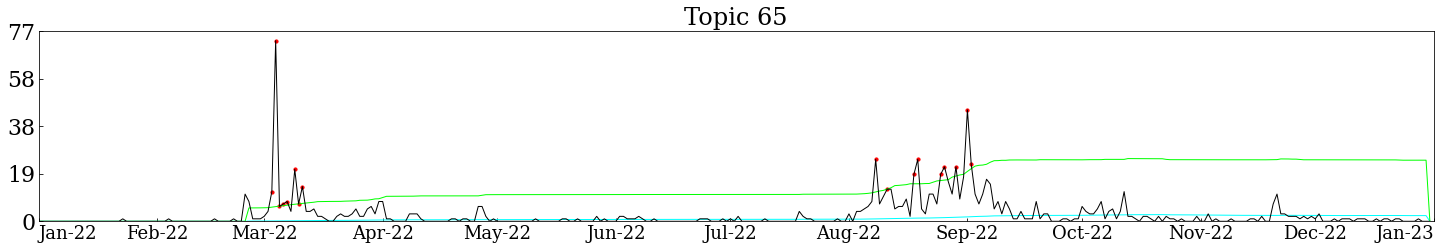

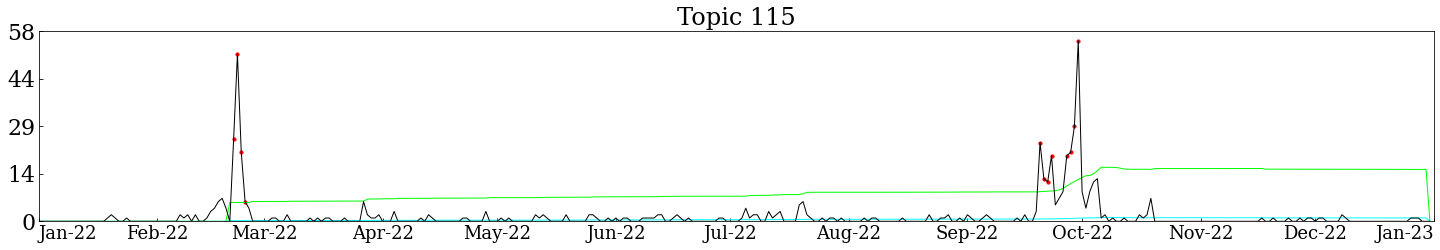

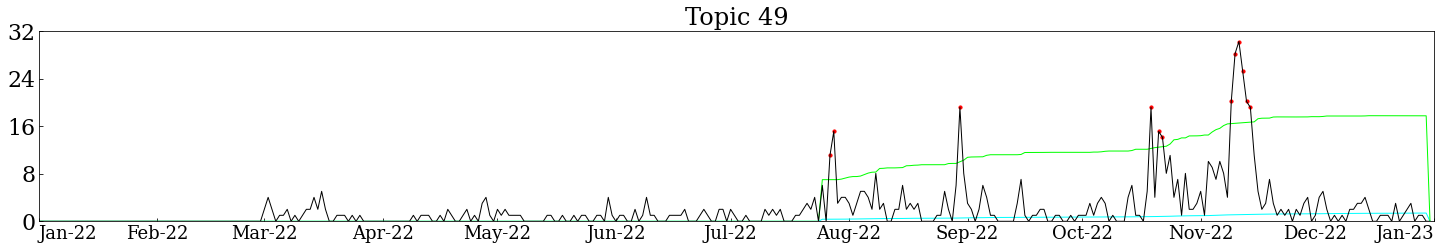

In [20]:
kwargs2 = {
    "All":[
    {"topic":65,"lag":240,"threshold":6},
    {"topic":115,"lag":235,"threshold":7},
    {"topic":49,"lag":390,"threshold":8},
    # {"topic":1,"lag":238,"threshold":15}, #
    # {"topic":2,"lag":235,"threshold":9}, #
    # {"topic":10,"lag":230,"threshold":5}, #
    # {"topic":16,"lag":235,"threshold":7}, # 
    # {"topic":21,"lag":350,"threshold":7}, #
    # {"topic":30,"lag":265,"threshold":5}, #
    # {"topic":51,"lag":460,"threshold":8}, # 
    # {"topic":110,"lag":235,"threshold":6}, # 
    # {"topic":128,"lag":235,"threshold":15}, #
    # {"topic":131,"lag":240,"threshold":13}, #
    # {"topic":152,"lag":240,"threshold":12}, #
    # {"topic":153,"lag":500,"threshold":8}, #
    # {"topic":176,"lag":238,"threshold":5.5}, #
    # {"topic":184,"lag":239,"threshold":5}, #
    # {"topic":0,"lag":314,"threshold":7}, 
    # {"topic":9,"lag":385,"threshold":5.5},
    # {"topic":12,"lag":300,"threshold":7}, 
    # {"topic":15,"lag":413,"threshold":14},
    # {"topic":19,"lag":330,"threshold":5},
    # {"topic":31,"lag":450,"threshold":7},
    # {"topic":35,"lag":340,"threshold":6},
    # {"topic":39,"lag":200,"threshold":2},
    # {"topic":40,"lag":285,"threshold":8},
    # {"topic":41,"lag":240,"threshold":8},
    # {"topic":44,"lag":240,"threshold":8},
    # {"topic":50,"lag":240,"threshold":15},
    # {"topic":56,"lag":270,"threshold":13},
    # {"topic":61,"lag":240,"threshold":3},
    # {"topic":68,"lag":355,"threshold":6},
    # {"topic":72,"lag":430,"threshold":6},
    # {"topic":80,"lag":235,"threshold":15},
    # {"topic":81,"lag":240,"threshold":9},
    # {"topic":87,"lag":260,"threshold":6},
    # {"topic":95,"lag":240,"threshold":7},
    # {"topic":97,"lag":464,"threshold":16},
    # {"topic":107,"lag":460,"threshold":7},
    # {"topic":114,"lag":248,"threshold":7},
    # {"topic":117,"lag":443,"threshold":9},
    # {"topic":122,"lag":265,"threshold":6},
    # {"topic":134,"lag":240,"threshold":5},
    # {"topic":136,"lag":425,"threshold":5},
    # {"topic":149,"lag":250,"threshold":25},
    # {"topic":159,"lag":278,"threshold":7},
    # {"topic":161,"lag":265,"threshold":6},
    # {"topic":163,"lag":250,"threshold":7},
    # {"topic":164,"lag":248,"threshold":10},
    # {"topic":166,"lag":518,"threshold":5},
    # {"topic":169,"lag":237,"threshold":5},
    # {"topic":177,"lag":292,"threshold":5},
    # {"topic":180,"lag":237,"threshold":15},
    # {"topic":181,"lag":245,"threshold":9},
    # {"topic":185,"lag":500,"threshold":23},
    # {"topic":194,"lag":245,"threshold":9},
    ]
}

data_df = pd.read_csv(os.path.join(ROOT_DIR, "results_10", "All_Results.csv"), parse_dates=["Date"], index_col=["Date"])
data_df = pd.get_dummies(data_df.filter(["Topic"]), columns=['Topic'])
data_df = data_df.resample("D").sum()

for i in range(0,len(kwargs2["All"])):
    fig3 = peaks_plot("All",data_df,**kwargs2["All"][i])
    topic = kwargs2["All"][i]["topic"]
    fig3.savefig(os.path.join(ROOT_DIR, "figures","peak_detection", f"peak_detection_topic_{topic}.svg"), format="svg", dpi=1000, bbox_inches="tight")
